In [13]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 250)

### Hyperpartisan

In [117]:
# !cd ..;python parse_tb.py

In [118]:
# res_df[(res_df.from_pretrained == 'bert-base-cased') & (res_df.input_seq_len == 818)]

In [139]:
paths = ['../results/hyp_grid.csv',
         '../results/hyp.csv',
         '../results/hyp_new.csv',
         '../results/results_sbc/hyp_grid.csv'
        ]
         
         

In [140]:
res_df = pd.concat([pd.read_csv(p) for p in paths])

In [137]:
res_df_debug = pd.read_csv('../results/debug_hyp.csv')
res_df['sum_loss'] = False
res_df_debug['sum_loss'] = True
res_df = pd.concat((res_df, res_df_debug))
res_df.input_seg_size = res_df.input_seg_size.fillna(512)

In [80]:
res_df = res_df.drop_duplicates()
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna(0)
res_df = res_df[res_df.f1 > 0]

In [4]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss']
metric_cols = ['f1', 'best_valid_f1']

group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['f1_std'] = res_df.groupby(gb_cols).std()[['f1']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['f1']
group_df['runs'] = res_df.groupby(gb_cols).agg({'f1':tuple}).f1.apply(lambda x: [round(i,2) for i in x])
# group_df

NameError: name 'res_df' is not defined

In [ ]:
# group_df.to_csv('../results/grouped/hyp.csv')

### contract-nli

In [183]:
paths = [
        '../results/cnli.csv',
        '../results/contract_nli.csv',
         '../results/debug_cnli.csv',
        ]
         

In [184]:
res_df = pd.concat([pd.read_csv(p) for p in paths])
res_df.sum_loss = res_df.sum_loss.fillna(False)
res_df.segment_ordering = res_df.segment_ordering.fillna('regular')
# res_df.padding_side = res_df.padding_side.fillna('left')
res_df.inter_layer_memory = res_df.inter_layer_memory.fillna('False')
res_df = res_df[res_df.num_steps.isin({3000, 5000})]
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df['n_seg'] = (res_df.input_seq_len / res_df.input_seg_size).apply(math.ceil)
res_df.fillna('UNKNOWN', inplace=True)

In [185]:
# res_df = res_df[res_df.best_valid_exact_match > 65]

In [186]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']#, 'batch_size']
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
# group_df

### by memory size

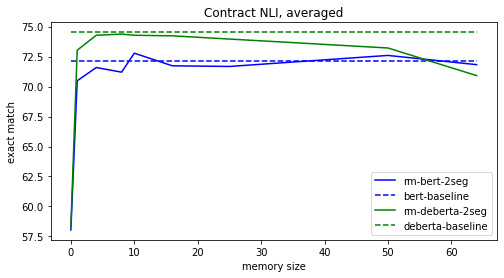

In [154]:
plt.figure(figsize=(8,4))
    
gb_cols = ['input_seg_size', 'input_seq_len','n_seg', 'num_mem_tokens']
metric = 'best_valid_exact_match'

models = ['bert-base-cased', 'microsoft/deberta-v3-base']
colors = ['b', 'green']
baseline_ems = [72.16, 74.53]

for i, model in enumerate(models):
    gb_cols = ['input_seg_size', 'n_seg', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']
    slice = res_df[res_df.from_pretrained == model]
    mask =  (slice.n_seg == 2)
    slice = slice[mask]

    slice_df = slice.groupby(gb_cols).mean()[[metric]]
    slice_df = slice_df.reset_index().sort_values('num_mem_tokens')

    exp_params = ['num_mem_tokens', 'n_seg']
    group_df = slice_df.groupby(exp_params).max([[metric]])
    group_df = group_df.reset_index().sort_values('num_mem_tokens')
    
    
    
    plt.plot(group_df.num_mem_tokens, group_df[metric], c=colors[i])
    
    plt.hlines(baseline_ems[i], 0, 64, color=colors[i], linestyle='--')
    


plt.title('Contract NLI, averaged')
plt.xlabel('memory size')
plt.ylabel('exact match')
plt.legend(['rm-bert-2seg','bert-baseline', 'rm-deberta-2seg', 'deberta-baseline'])


plt.show()


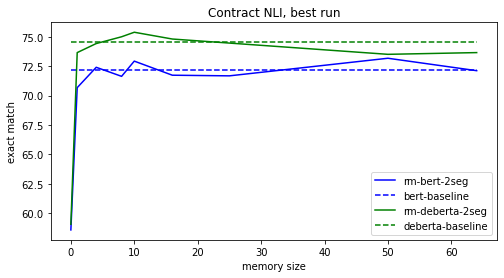

In [155]:
plt.figure(figsize=(8,4))
    
gb_cols = ['input_seg_size', 'input_seq_len','n_seg', 'num_mem_tokens']
metric = 'best_valid_exact_match'

models = ['bert-base-cased', 'microsoft/deberta-v3-base']
colors = ['b', 'green']
baseline_ems = [72.16, 74.53]

for i, model in enumerate(models):
    gb_cols = ['input_seg_size', 'n_seg', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']
    slice = res_df[res_df.from_pretrained == model]
    mask =  (slice.n_seg == 2)
    slice = slice[mask]

    slice_df = slice.groupby(gb_cols).max()[[metric]]
    slice_df = slice_df.reset_index().sort_values('num_mem_tokens')

    exp_params = ['num_mem_tokens', 'n_seg']
    group_df = slice_df.groupby(exp_params).max([[metric]])
    group_df = group_df.reset_index().sort_values('num_mem_tokens')
    
    
    
    plt.plot(group_df.num_mem_tokens, group_df.best_valid_exact_match, c=colors[i])
    
    plt.hlines(baseline_ems[i], 0, 64, color=colors[i], linestyle='--')
    


plt.title('Contract NLI, best run')
plt.xlabel('memory size')
plt.ylabel('exact match')
plt.legend(['rm-bert-2seg','bert-baseline', 'rm-deberta-2seg', 'deberta-baseline'])


plt.show()


### by segment number

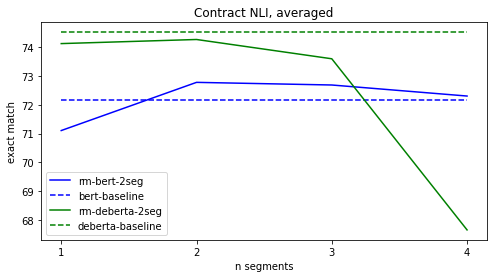

In [169]:
plt.figure(figsize=(8,4))
    
gb_cols = ['input_seg_size', 'input_seq_len','n_seg', 'num_mem_tokens']
metric = 'best_valid_exact_match'

models = ['bert-base-cased', 'microsoft/deberta-v3-base']
colors = ['b', 'green']
baseline_ems = [72.16, 74.53]

for i, model in enumerate(models):
    gb_cols = ['input_seg_size', 'n_seg', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']
    slice = res_df[res_df.from_pretrained == model]
    mask =  (slice.num_mem_tokens == 10)
    slice = slice[mask]

    slice_df = slice.groupby(gb_cols).mean()[[metric]]
    slice_df = slice_df.reset_index().sort_values('num_mem_tokens')

    exp_params = ['n_seg']
    group_df = slice_df.groupby(exp_params).max([[metric]])
    group_df = group_df.reset_index().sort_values('num_mem_tokens')
    
    
    
    plt.plot(group_df.n_seg, group_df[metric], c=colors[i])
    
    plt.hlines(baseline_ems[i], 1, 4, color=colors[i], linestyle='--')
    


plt.title('Contract NLI, averaged')
plt.xlabel('n segments')
plt.ylabel('exact match')
plt.legend(['rm-bert-2seg','bert-baseline', 'rm-deberta-2seg', 'deberta-baseline'])

plt.xticks([1,2,3,4])
plt.show()


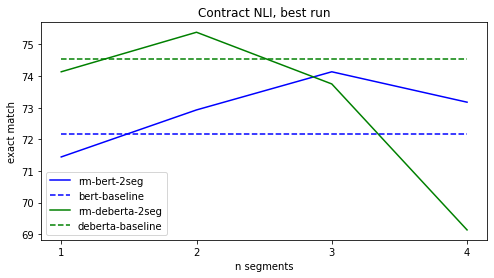

In [171]:
plt.figure(figsize=(8,4))
    
gb_cols = ['input_seg_size', 'input_seq_len','n_seg', 'num_mem_tokens']
metric = 'best_valid_exact_match'

models = ['bert-base-cased', 'microsoft/deberta-v3-base']
colors = ['b', 'green']
baseline_ems = [72.16, 74.53]

for i, model in enumerate(models):
    gb_cols = ['input_seg_size', 'n_seg', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']
    slice = res_df[res_df.from_pretrained == model]
    mask =  (slice.num_mem_tokens == 10)
    slice = slice[mask]

    slice_df = slice.groupby(gb_cols).max()[[metric]]
    slice_df = slice_df.reset_index().sort_values('num_mem_tokens')

    exp_params = ['n_seg']
    group_df = slice_df.groupby(exp_params).max([[metric]])
    group_df = group_df.reset_index().sort_values('num_mem_tokens')
    
    
    
    plt.plot(group_df.n_seg, group_df[metric], c=colors[i])
    
    plt.hlines(baseline_ems[i], 1, 4, color=colors[i], linestyle='--')
    


plt.title('Contract NLI, best run')
plt.xlabel('n segments')
plt.ylabel('exact match')
plt.legend(['rm-bert-2seg','bert-baseline', 'rm-deberta-2seg', 'deberta-baseline'])

plt.xticks([1,2,3,4])
plt.show()


## influence of flags

In [233]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']#, 'batch_size']
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
# group_df

Text(0, 0.5, 'number of experiments')

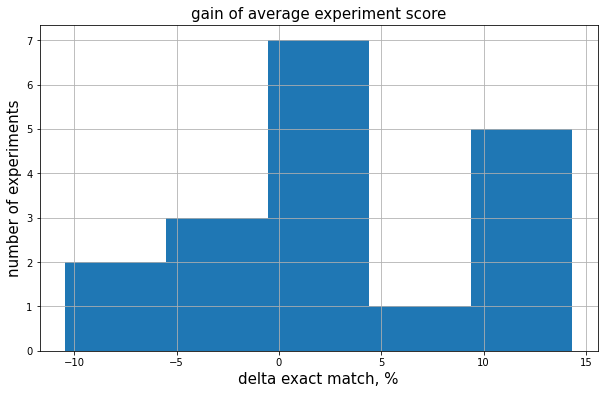

In [230]:
flag = 'sum_loss'
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']#, 'batch_size']
merged = gb_df.merge(gb_df_copy[gb_cols + ['best_valid_exact_match']], on=gb_cols, how='inner', suffixes=('', f'_{flag}'))
merged = merged[~merged[flag]]
merged[f'{flag}_added'] = merged[f'best_valid_exact_match_{flag}'] - merged.best_valid_exact_match

merged.sum_loss_added.hist(bins=5, figsize=(10,6))
plt.title('gain of average experiment score', fontsize=15)
plt.xlabel('delta exact match, %', fontsize=15)
plt.ylabel('number of experiments', fontsize=15)

In [235]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']#, 'batch_size']
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_exact_match  \
from_pretrained           input_seg_size input_seq_len num_mem_tokens lr       lr_scheduler         sum_loss segment_ordering inter_layer_memory                           
bert-base-cased           512.0          484           0              0.000010 linear               True     repeat_first     False                            70.625000   
                                                       25             0.000010 linear               True     repeat_first     False                            70.312498   
                                         499           0              0.000010 linear               True     repeat_first     False                            70.961540   
                                                       10             0.000010 linear               True     repeat_first     False                            71.105770   
                                         890           64             0.000010 linear               True     regular          False                            71.826923   
                                         918           50             0.000010 linear               False    regular          False                            72.596157   
                                                                                                    True     regular          False                            72.350677   
                                         968           25             0.000010 linear               True     regular          True                             71.676300   
                                         986           16             0.000010 linear               True     regular          False                            71.730766   
                                         998           0              0.000010 linear               True     regular          False                            58.044315   
                                                       10             0.000005 linear               True     regular          False                            70.817307   
                                                                      0.000008 linear               True     regular          False                            72.403847   
                                                                      0.000010 constant_with_warmup True     regular          False                            72.784203   
                                                                               linear               True     bidirectional    False                            72.067307   
                                                                                                             regular          False                            71.820812   
                                                                                                             repeat_first     False                            71.298079   
                                                                      0.000015 linear               True     regular          False                            71.538460   
                                         1002          8              0.000010 linear               True     regular          False                            71.201923   
                                         1010          4              0.000010 linear               True     regular          False                            71.586540   
                                         1016          1              0.000010 linear               True     regular          False                            70.480770   
                                         1377          50             0.000010 linear               False    regular          False                            72.163464   
                                                                                                    True     regular          False                            72.447014   
                  

In [240]:
# gb_df = group_df.reset_index()
# gb_df_comp = gb_df.copy()

# gb_df_comp.sum_loss = ~gb_df_copy[

# gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']#, 'batch_size']
# merged = gb_df.merge(gb_df_copy[gb_cols + ['best_valid_exact_match']], on=gb_cols, how='inner', suffixes=('', f'_{flag}'))
# merged = merged[~merged[flag]]
# merged[f'{flag}_added'] = merged[f'best_valid_exact_match_{flag}'] - merged.best_valid_exact_match

# merged.sum_loss_added.hist(bins=5, figsize=(10,6))
# plt.title('gain of average experiment score', fontsize=15)
# plt.xlabel('delta exact match, %', fontsize=15)
# plt.ylabel('number of experiments', fontsize=15)

In [228]:
merged[['from_pretrained','input_seq_len', 'num_mem_tokens',
       'lr', 'lr_scheduler', 'best_valid_exact_match', 'sum_loss_added']].sort_values('sum_loss_added', ascending=False)

,from_pretrained,input_seq_len,num_mem_tokens,lr,lr_scheduler,best_valid_exact_match,sum_loss_added
34,t5-base,1002,10,0.00200,linear,58.525999,14.334600
22,t5-base,972,25,0.00200,linear,58.092501,13.950775
6,microsoft/deberta-v3-base,1377,50,0.00001,linear,57.067308,10.851767
32,t5-base,1002,10,0.00200,constant_with_warmup,62.475899,9.767670
10,roberta-base,1377,50,0.00001,linear,63.557693,9.611862
20,t5-base,972,25,0.00200,constant_with_warmup,64.932550,7.214918
24,t5-base,1002,10,0.00050,constant_with_warmup,71.820801,1.863767
26,t5-base,1002,10,0.00050,linear,69.556850,0.969824
4,microsoft/deberta-v3-base,918,50,0.00001,linear,72.355770,0.861958
16,t5-base,972,25,0.00100,constant_with_warmup,71.531799,0.743869


Text(0, 0.5, 'number of experiments')

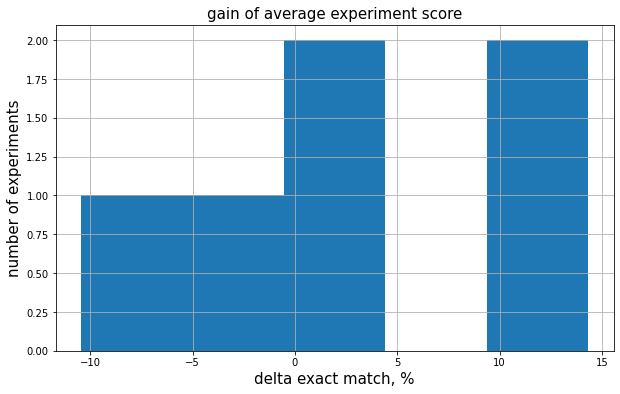

In [207]:
gb_df = group_df.reset_index()
gb_df_copy = gb_df.copy()
gb_df_copy.sum_loss = ~gb_df_copy.sum_loss

merged = gb_df.merge(gb_df_copy[gb_cols + ['best_valid_exact_match']], on=gb_cols, how='inner', suffixes=('', '_sum_loss'))
merged = merged[~merged.sum_loss]
merged['sum_loss_added'] = merged.best_valid_exact_match_sum_loss - merged.best_valid_exact_match
# merged
merged = merged[merged.num_mem_tokens == 10]

merged.sum_loss_added.hist(bins=5, figsize=(10,6))
plt.title('gain of average experiment score', fontsize=15)
plt.xlabel('delta exact match, %', fontsize=15)
plt.ylabel('number of experiments', fontsize=15)

In [208]:
merged

,from_pretrained,input_seg_size,input_seq_len,num_mem_tokens,lr,lr_scheduler,sum_loss,segment_ordering,inter_layer_memory,best_valid_exact_match,std,n_runs,runs,best_valid_exact_match_sum_loss,sum_loss_added
24,t5-base,512.0,1002,10,0.0005,constant_with_warmup,False,regular,False,71.820801,0.885577,2,"[71.19, 72.45]",73.684568,1.863767
26,t5-base,512.0,1002,10,0.0005,linear,False,regular,False,69.556850,2.588645,2,"[67.73, 71.39]",70.526674,0.969824
28,t5-base,512.0,1002,10,0.0010,constant_with_warmup,False,regular,False,68.930653,3.746746,2,"[66.28, 71.58]",68.076200,-0.854453
30,t5-base,512.0,1002,10,0.0010,linear,False,regular,False,72.206203,0.476873,2,"[71.87, 72.54]",61.751433,-10.454770
32,t5-base,512.0,1002,10,0.0020,constant_with_warmup,False,regular,False,62.475899,8.787778,2,"[68.69, 56.26]",72.243568,9.767670
34,t5-base,512.0,1002,10,0.0020,linear,False,regular,False,58.525999,0.885580,2,"[59.15, 57.9]",72.860600,14.334600


### qasper

In [ ]:
# !cd ..;python parse_tb.py

In [236]:
res_df = pd.read_csv('../results/qasper.csv')


In [241]:
# res_df = res_df[res_df.best_valid_f1 > 6]
res_df = res_df[res_df.num_steps.isin({1600})]

res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df.inter_layer_memory = res_df.inter_layer_memory.fillna(False)
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna(-1)
res_df.sum_loss = res_df.sum_loss.fillna(False)
res_df.segment_ordering = res_df.segment_ordering.fillna('regular')
res_df.padding_side = res_df.padding_side.fillna('left')
res_df.fillna('UNKNOWN', inplace=True)
res_df['n_seg'] = (res_df.input_seq_len / res_df.input_seg_size).apply(math.ceil)

In [243]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len','n_seg', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering', 'padding_side', 'inter_layer_memory']
metric_cols = ['best_valid_f1']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_f1']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_f1']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_f1':tuple}).best_valid_f1.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_f1  \
from_pretrained input_seg_size input_seq_len n_seg num_mem_tokens lr      lr_scheduler sum_loss segment_ordering padding_side inter_layer_memory                  
t5-base         256.0          512           2      10.0          0.00020 linear       True     repeat_first     left         False                   14.770700   
                               768           3      10.0          0.00020 linear       True     repeat_first     left         False                   15.114600   
                               1024          4      10.0          0.00020 linear       True     repeat_first     left         False                   14.248900   
                512.0          486           1      0.0           0.00020 linear       True     regular          left         False                   19.148500   
                                                    25.0          0.00020 linear       True     repeat_first     left         False                   16.539075   
                               499           1      0.0           0.00020 linear       True     regular          left         False                   19.231800   
                                                    10.0          0.00020 linear       True     regular          left         False                   17.046301   
                                                                                                repeat_first     left         False                   17.265100   
                               512           1     -1.0           0.00020 linear       False    regular          left         False                   19.464899   
                                                    0.0           0.00020 linear       True     regular          left         False                   19.496100   
                               972           2      25.0          0.00010 linear       True     repeat_first     left         False                   13.446550   
                                                                  0.00020 linear       True     regular          left         False                   11.792767   
                                                                                                repeat_first     left         False                   15.455400   
                               1002          2      10.0          0.00005 linear       False    regular          left         False                   10.494500   
                                                                                       True     regular          left         False                   10.908867   
                                                                                                repeat_first     left         False                   12.121700   
                                                                  0.00010 linear       False    regular          left         False                   10.929900   
                                                                                       True     regular          left         False                   11.165933   
                                                                                                repeat_first     left         False                   13.840866   
                                                                  0.00020 linear       False    repeat_first     left         False                   15.143000   
                                                                                       True     regular          left         False                   12.361333   
                                                                                                repeat_first     left         False                   15.748167   
                                                                  0.00050 linear       True     repeat_first     left         False                   15.385500   
                                                                  0.001

In [258]:
gb_df = group_df.reset_index()
# mask = (gb_df.input_seg_size == 512) & (gb_df.n_seg == 2) & (gb_df.num_mem_tokens == 10) & (gb_df.sum_loss)
mask = (gb_df.input_seg_size == 512) & (gb_df.n_seg >1) & (gb_df.sum_loss)# & (gb_df.lr==0.0002)
display_cols = ['from_pretrained', 'n_seg', 'num_mem_tokens', 'lr', 'segment_ordering', 'best_valid_f1', 'std']
gb_df[mask][display_cols].sort_values(['n_seg', 'num_mem_tokens', 'lr'])


,from_pretrained,n_seg,num_mem_tokens,lr,segment_ordering,best_valid_f1,std
14,t5-base,2,10.0,0.00005,regular,10.908867,0.361245
15,t5-base,2,10.0,0.00005,repeat_first,12.121700,0.632740
17,t5-base,2,10.0,0.00010,regular,11.165933,0.426457
18,t5-base,2,10.0,0.00010,repeat_first,13.840866,0.614144
20,t5-base,2,10.0,0.00020,regular,12.361333,0.332936
21,t5-base,2,10.0,0.00020,repeat_first,15.748167,0.444623
22,t5-base,2,10.0,0.00050,repeat_first,15.385500,0.639162
23,t5-base,2,10.0,0.00100,repeat_first,15.187100,0.869672
10,t5-base,2,25.0,0.00010,repeat_first,13.446550,0.148563
11,t5-base,2,25.0,0.00020,regular,11.792767,0.270566


In [250]:
gb_df[mask].groupby(['from_pretrained', 'n_seg', 'num_mem_tokens',]

### qmsum

In [173]:
res_df = pd.read_csv('../results/qmsum.csv')

In [174]:
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)
res_df['n_seg'] = (res_df.input_seq_len / res_df.input_seg_size).apply(math.ceil)

In [175]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering']
metric_cols = ['best_valid_rouge/geometric_mean']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = res_df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = res_df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

### by memory

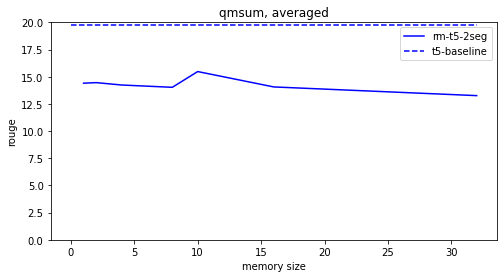

In [176]:
plt.figure(figsize=(8,4))
    
gb_cols = ['input_seg_size', 'input_seq_len','n_seg', 'num_mem_tokens']
metric = 'best_valid_rouge/geometric_mean'

models = ['t5-base']
colors = ['b']
baseline_ems = [19.76]

for i, model in enumerate(models):
    gb_cols = ['input_seg_size', 'n_seg', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']
    slice = res_df[res_df.from_pretrained == model]
    mask =  (slice.n_seg == 2) & (slice.lr == 0.0002)
    slice = slice[mask]

    slice_df = slice.groupby(gb_cols).mean()[[metric]]
    slice_df = slice_df.reset_index().sort_values('num_mem_tokens')

    exp_params = ['num_mem_tokens', 'n_seg']
    group_df = slice_df.groupby(exp_params).max([[metric]])
    group_df = group_df.reset_index().sort_values('num_mem_tokens')
    
    
    
    plt.plot(group_df.num_mem_tokens, group_df[metric], c=colors[i])
    
    plt.hlines(baseline_ems[i], 0, 32, color=colors[i], linestyle='--')
    


plt.title('qmsum, averaged')
plt.xlabel('memory size')
plt.ylabel('rouge')
plt.legend(['rm-t5-2seg', 't5-baseline'])

plt.ylim(0, 20)

plt.show()


In [37]:
# group_df.sort_values('best_valid_rouge/geometric_mean')

### quality

In [23]:
# !cd ..;python parse_tb.py

In [24]:
res_df = pd.read_csv('../results/quality.csv')
# res_df = pd.concat((pd.read_csv('results/results_sbc/quality.csv'),))
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
# res_df.padding_side = res_df.padding_side.fillna('left')

In [25]:
res_df = res_df[res_df.best_valid_exact_match > 10]

In [26]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler']
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_exact_match  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler                           
t5-base         512.0          998           10             0.00005 linear                     28.395667   
                                                            0.00010 linear                     30.021550   

                                                                                       std  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler             
t5-base         512.0          998           10             0.00005 linear        0.508137   
                                                            0.00010 linear        0.167795   

                                                                                  n_runs  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler           
t5-base         512.0          998           10             0.00005 linear             3   
                                                            0.00010 linear             4   

                                                                                                         runs  
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler                               
t5-base         512.0          998           10             0.00005 linear              [27.85, 28.48, 28.86]  
                                                            0.00010 linear        [29.82, 30.11, 30.2, 29.96]